Device is  cuda
torch.Size([128, 1, 28, 28])
cuda:0
torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])
Epoch [0], val_loss: 0.2368, val_acc: 0.9292
Epoch [1], val_loss: 0.1911, val_acc: 0.9396
Epoch [2], val_loss: 0.1696, val_acc: 0.9492
Epoch [3], val_loss: 0.1504, val_acc: 0.9546
Epoch [4], val_loss: 0.1619, val_acc: 0.9537


Text(0.5, 1.0, 'Accuracy vs. # of epochs')

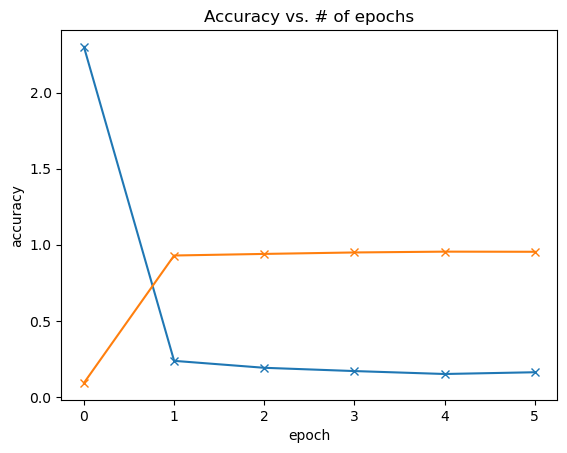

In [3]:
#TRAINING DEEP NEURAL NETWORKS ON GPUS

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
%matplotlib inline

torch.cuda.is_available()

def get_default_device():
    """Pick GPU available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print("Device is ", device)

def to_device(data,device):
    """Move tensors to chosen device"""
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


dataset = MNIST('data/', download=True, transform = ToTensor())

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)



for images, labels in train_loader:
    print(images.shape)
    images = to_device(images,device)
    print(images.device)
    break


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MnistModel(nn.Module):
    #Feedforward neural network with 1 hidden layer
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        #Flatten the image to tensors
        xb = xb.view(xb.size(0), -1)
        #Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        #Apply activation function
        out = F.relu(out)
        #Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  #Generate predictions
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  #Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    #Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    #Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


input_size = 784
hidden_size = 32
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size= num_classes)

#Let's check model paremeters
for t in model.parameters():
    print(t.shape)


#Training and evaluation starts here
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

#Before training starts, let's be sure that model parameters and data are on same device
#Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

history = [evaluate(model, val_loader)]
history

history += fit(5, 0.5, model, train_loader, val_loader)

losses = [x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. # of epochs')

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. # of epochs')